# 9/17 : Twitter Sentiment Analysis

Hi everyone! In this notebook, we'll take a look at **sentiment analysis**. Specifically, we'll see how we can predict the emotion of a tweet!

In this notebook, we have the following methods for you to fill out:
1. `add_tweet()`
2. `extract_features()`
3. `get_accuracy()`
4. `predict_tweet()`

We'll start with our needed imports

You may notice that some of these imports are different from the ones we usually use. `numpy` is, of course, the library we are most familiar with. `pandas` is a library for data management (similar to SQL), while `nltk` is a library specifically for NLP

In [1]:
# libraries
import re
import string
import nltk
import pandas as pd
import numpy as np
from os import getcwd
# features from nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

Next, we'll download the data we need and set our work directory (so we don't have to download these files every time we open the notebook)

In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\nishu\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nishu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now that we have the data we need, we can format it in the way we need:

In [3]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# separate our data into negative and positive labels
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

# separate our data into training and testing sets (remember, around 80/20)
train_x = train_pos + train_neg 
test_x = test_pos + test_neg
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

## Now that our data is formatted, we can follow our steps for sentiment analysis:

1. `Process` our tweets
2. `Build` our dictionary
3. `Train` our model
4. `Test` our model

## Step 1: `Processing` our tweets

We have this method filled out for you, since almost all of it uses nltk functions and it's a bit confusing

Basically, it performs all the steps we discussed in the slides, including: removing `punctuation` and `stopwords`, `tokenizing`, and removing random `twitter symbols` (like @ and #)

Feel free to take a look if you want to see how it works in depth!

In [4]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        # remove stopwords and punctuation
        if (word not in stopwords_english and word not in string.punctuation):
            # stem the word and add it to our list
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    
    # return our tweets
    return tweets_clean

Run the cell below to see what happens to the given tweet after it's processed

Try it out with your own tweet!

*Fun fact: the Kanye tweet below might be my favorite tweet of all time*

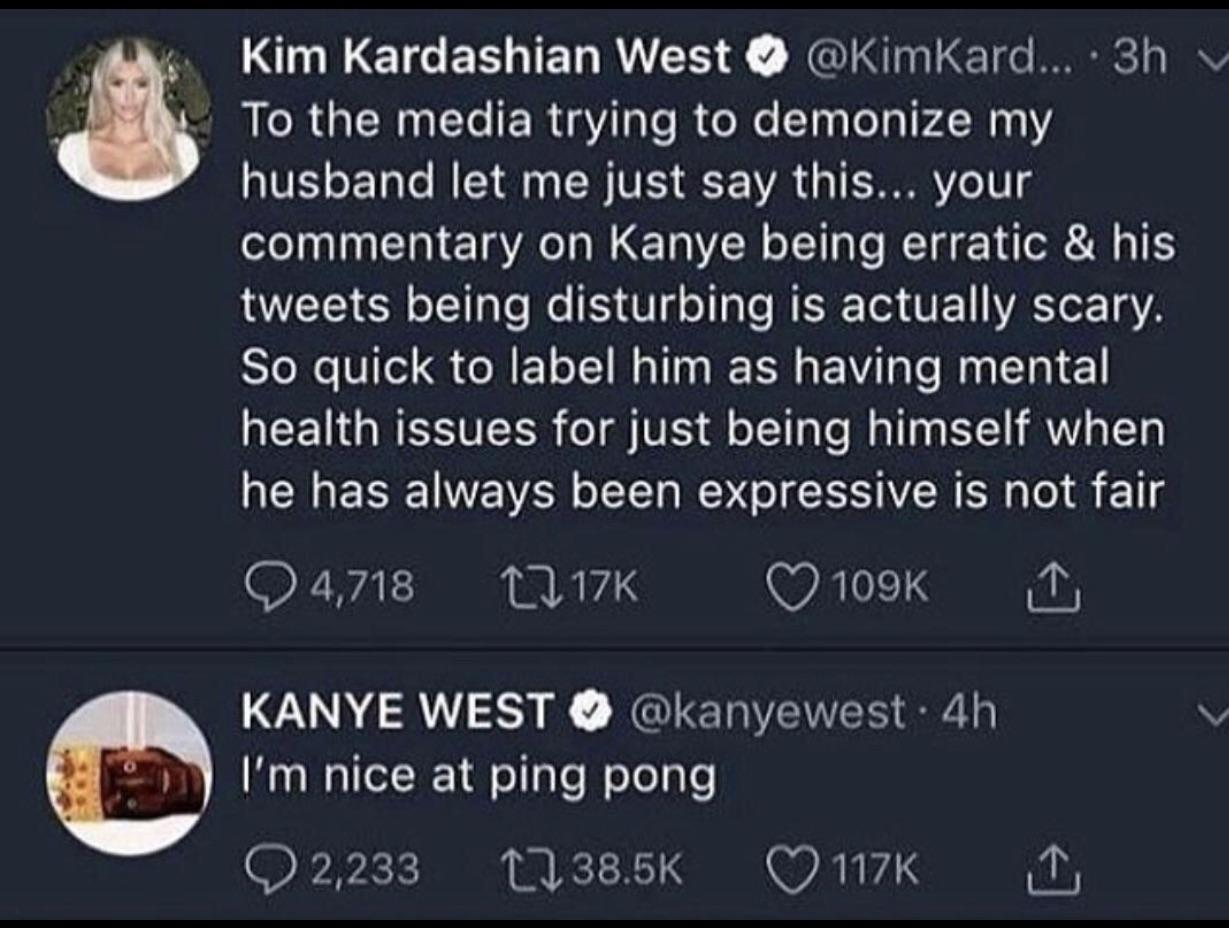

In [5]:
from IPython.display import Image
Image(filename = "./kanye_tweet.jpg", width=400, height=400)

In [6]:
# try your own tweet here!
sample_processed_tweet = "I'm nice at ping pong"
print(process_tweet(sample_processed_tweet))

["i'm", 'nice', 'ping', 'pong']


## Step 2: `Building` our dictionary

In [7]:
def build_dict(tweets, sentiments):
    # initialize the dictionary
    tweet_dict = dict({})
    # iterate through each tweet, and add it to the dictionary
    for tweet_num in range(len(tweets)):
        add_tweet(tweet_dict, tweets[tweet_num], int(sentiments[tweet_num][0]))
    # return the dictionary
    return tweet_dict

In [8]:
def add_tweet(dictionary, tweet, sentiment):
    # creates the tokens from the tweet
    tokenized_tweet = process_tweet(tweet)
    # iterates through each token
    for token in tokenized_tweet:
        # if the token is in the dictionary, freqs is that value, [0, 0] otherwise
        if (token in dictionary):
            freqs = dictionary[token]
        else:
            freqs = [0, 0]
        # increases the appropriate frequency and updates the dictionary
        freqs[sentiment] += 1
        dictionary.update({token : freqs})

In [9]:
tweet_dict = build_dict(train_x, train_y)

## Step 3: `Training` our model

Before we run gradient descent, let's define the functions that we used last week, namely:
1. `sigmoid()` - our function for mapping values between 0 and 1
2. `cost()` - the cost of the logistic regression
3. `cost_derivative()` - the derivative of the cost function

If you want to learn more about how these functions work/why we need them, you can look at the materials from last week

In [10]:
def sigmoid(x):
    sigmoid_val = 1 / (1 + np.exp(-x))
    return sigmoid_val

In [11]:
def cost(y_pred, y_actual, m):
    cost = (-1 / m) * np.sum(y_actual.T @ np.log(y_pred) + (1 - y_actual).T @ np.log(1 - y_pred))
    return cost

In [12]:
def cost_derivative(predicted, actual, inputs, m):
    derivative = (1 / m) * (inputs.T @ (predicted - actual))
    return derivative

Before we can train our model, we need to create a function to properly represent our words

Recall that each tweet can be represented as:

<img src="https://latex.codecogs.com/gif.latex?\dpi{300}&space;\begin{Bmatrix}&space;1&space;&&space;n_{neg}&space;&&space;n_{pos}&space;\end{Bmatrix}" title="\begin{Bmatrix} 1 & n_{neg} & n_{pos} \end{Bmatrix}" />


Where $n_{neg}$ is the number of times the words in the tweet appeared in a `negative` tweet, 

and $n_{pos}$ is the number of times the words in the tweet appeared in a `positive` tweet

Complete the function `extract_features()`, which transforms the tweet according to the instructions in the above cell

In [13]:
def extract_features(dictionary, tweet):
    processed_tweet = process_tweet(tweet)
    tweet_val = [1, 0, 0]
    for word in processed_tweet:
        freqs = dictionary.get(word, [0, 0])
        tweet_val[1] += freqs[0]
        tweet_val[2] += freqs[1]
    return tweet_val

Now, we can use `extract_features()` to build a training set!

In [14]:
def build_set(dictionary, tweets):
    tweet_set = []
    for tweet in tweets:
        tweet_val = extract_features(dictionary, tweet)
        tweet_set.append(tweet_val)
    return 1.0 * np.array(tweet_set)

In [15]:
# sets our training and testing sets for logistic regression
training_x = build_set(tweet_dict, train_x)
training_y = train_y

Our data is finally correctly formatted, so we can begin `logistic regression`!

We'll start by defining our constants for `logistic regression`

In [16]:
# constants for gradient descent
learning_rate = 0.000001
num_iterations = 15000
m = training_x.shape[0]
# initialize our thetas
thetas = np.zeros((3, 1))

Since you filled out the gradient descent function last week (hopefully!), we'll fill out the method for you this time

To understand more about how this algorithm works, feel free to look at the materials from last week!

In [17]:
def grad_descent(x, actual_y, thetas, learning_rate, m, num_iterations):
    # perform the algorithm for the specified number of iterations
    for iteration in range(num_iterations):
        # calculate our sigmoided predicted output
        pred_output = sigmoid(x @ thetas)
        # get the derivative of this value
        gradients = cost_derivative(pred_output, actual_y, x, m)
        # adjust our thetas
        thetas = thetas - learning_rate * gradients
    return thetas

Everything is ready, so let's train our model!

In [18]:
tweet_thetas = grad_descent(training_x, training_y, thetas, learning_rate, m, num_iterations)

## Step 4: `Testing` our model

Before we put in our own custom tweets, let's test our model using the testing data

Complete the function `get_accuracy()`, which returns the accuracy of our trained model

Accurancy can be defined as:

<img src="https://latex.codecogs.com/gif.latex?\dpi{200}&space;accuracy&space;=&space;\frac{n_{correct}}{n_{total}}" title="accuracy = \frac{n_{correct}}{n_{total}}" />

In [19]:
def get_accuracy(dictionary, x, y, thetas, m):
    # create the test set
    test_set = build_set(dictionary, x)
    # get the predicted values
    predicted_values = sigmoid(test_set @ thetas) > 0.5  
    # check how many of these values are correct
    num_correct = np.sum((predicted_values == y))
    # calculate and return the accuracy
    accuracy = num_correct / m
    return accuracy

Run the cell below to test the model's accuracy

In [20]:
accuracy = format(get_accuracy(tweet_dict, test_x, test_y, tweet_thetas, test_y.shape[0]))
print("Model accuracy: {0}".format(accuracy))

Model accuracy: 0.9945


If you see a model accuracy over 95%, that's pretty good!

## Step 4b: `Testing` with `custom tweets`

Now, let's use our model to predict our own custom tweets!

Complete the function `predict_tweet()` below so we can predict our own custom tweets!

In [21]:
def predict_tweet(dictionary, tweet, thetas):
    features = extract_features(dictionary, tweet)
    prediction = sigmoid(features @ thetas)
    return "Positive Sentiment" if prediction > 0.5 else "Negative Sentiment"

Test your function below with your own inputs!

In [22]:
tweet = "covfefe"
print(predict_tweet(tweet_dict, tweet, tweet_thetas))

Positive Sentiment
